# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

/Users/marceloqueiroz/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/marceloqueiroz/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [3]:
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

In [4]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape
print 'labels reordered:', Y

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)
labels reordered: [1. 9. 2. ... 7. 7. 8.]


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

In [5]:
print int(mini_train_labels[3])

2


/Users/marceloqueiroz/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


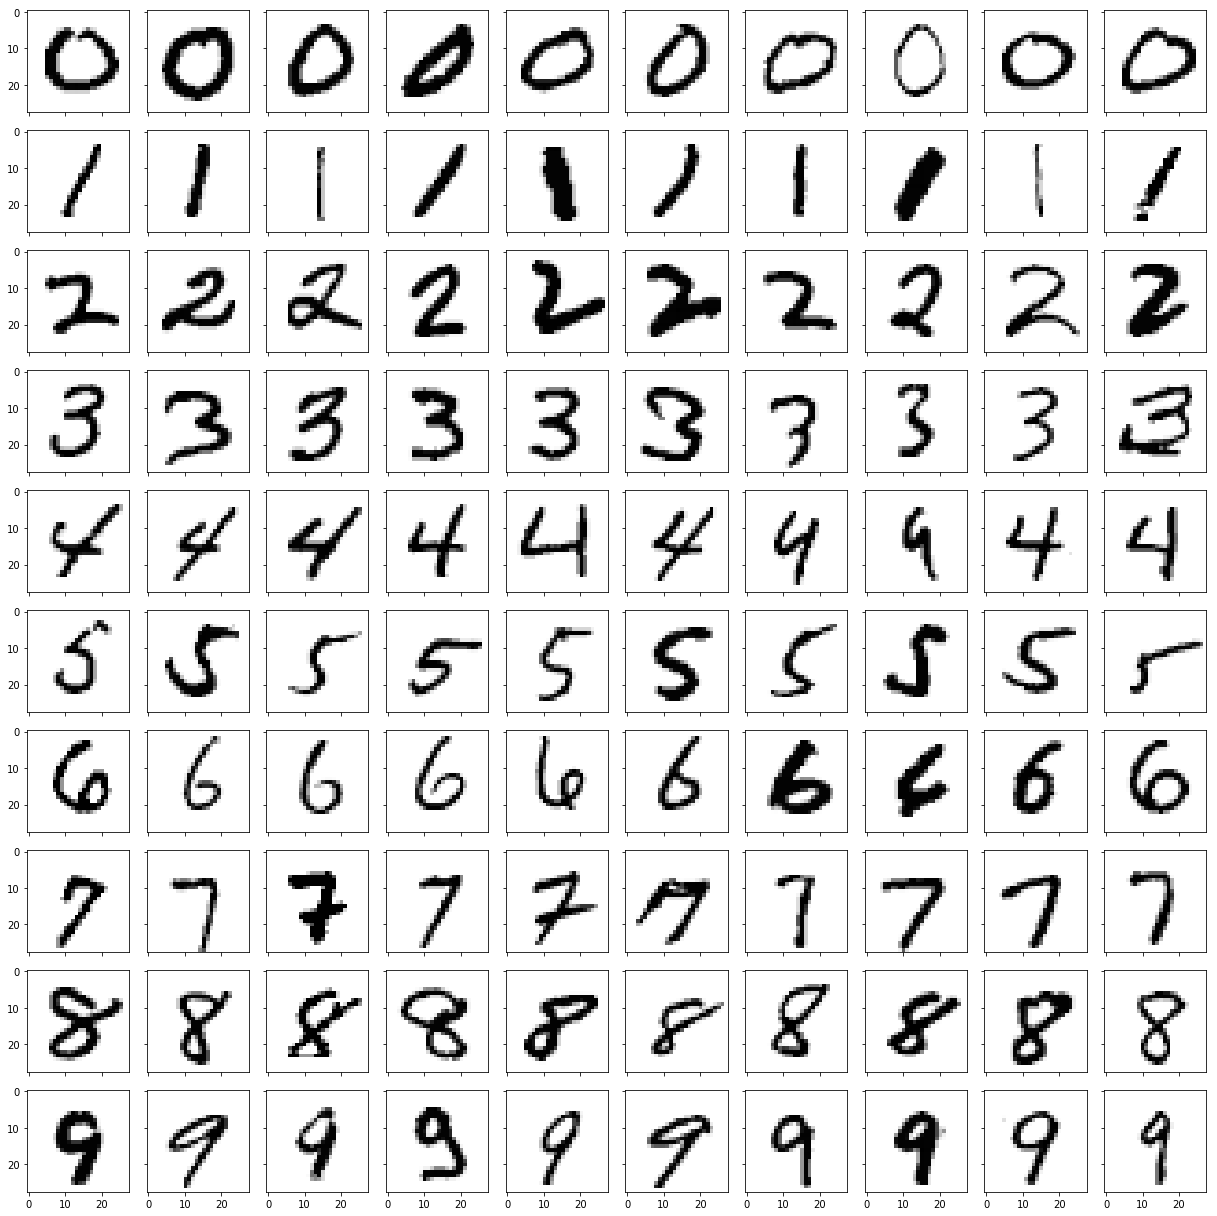

In [6]:
def P1(data, targets, num_examples=10):
    '''P1(data, targets, num_examples=10)
    
    - data: flat array representing the digits with values within 0~1 to represent ink.
    - targets: flat array with the labels for each of the numbers. Note that the indexes must match the data
      indexes to work. Remember to set the random seed before shiffling the datasets. Default is 10.
    - num_examples: number of examples of each digit to be ploted.
    
    Function to visualize 'num_examples' (default=10) examples of each digit coming from the given 'data' 
    and labeled by target. The output is 100 plots, 10 of each target digits contained in the training 
    dataset.'''
    
    examples = num_examples
    
    set_for_plt = [] #list of desired label indexes, in order.
    for i in np.arange(10):
        set_for_plt.extend(np.where(targets == i)[0][:num_examples])
    
    data_for_plot = [] #list of arrays that will be ploted.
    for i in set_for_plt:
        data_for_plot.append(data[i])
    
    #defining 
    fig, axes = plt.subplots(10,num_examples, 
                         figsize=(17,17),
                         sharex=True, sharey=True,
                         subplot_kw=dict(adjustable='box-forced', aspect='equal'))

    
    for i in range(len(data_for_plot)):
        
        subplot_row = i//num_examples 
        subplot_col = i%num_examples  
        ax = axes[subplot_row, subplot_col]

        # plot image on subplot
        img = np.reshape(data_for_plot[i], (28,28))
        ax.imshow(img, cmap='Greys')


    plt.tight_layout()
    plt.show()


P1(mini_train_data, mini_train_labels, 10)



(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [7]:
def P2(train_data, train_targets, test_data, test_targets, k_values=[1]):
    """
    P2(train_data, train_targets, test_data, test_targets, k_values)
    
    - train_data: array of matrices of digits used for training the model.
    - train_targets: array of labels of digits that must match train_data.
    - test_data: array of matrices of digits used for testing the model's performance.
    - test_targets: array of labels of digits that must match test_data.
    - k-values: list that contains the number of nearest nieghbors we will use for traning different 
      models and compare performance. Default value is [1] (only Nearest Neighbor will be tested).
      
    This function gets train and test datasets and fit one K-NearestNeighbors model for each of the 
    elements in k_values list. Accuracy is reported for each of the models and a list is returned containing:
    
    [k_values, accuracies, trues, predicted, confusion_matrix], where:
    
    - k_values: same list inputed.
    - accuracies: list of accuracies corresponding each k_values fitted models.
    - trues: array of labels that where trully identified (test_targets).
    - predicted: array of predicted labels for each model.
    - confusion_matrix: confusion matrix to verify results.
    
    The given results returned can then be used for more specifics performance calculations. 
    """
    
    accs = [] #list to record accuracy of the different models and for reporting later.
    
    #for each value in k_values we create a model, fit the given training data and targets against the test data.
    for i in k_values:
        mod = KNeighborsClassifier(n_neighbors= i)
        mod = mod.fit(train_data, train_targets)
        
        predicted = mod.predict(test_data)
        trues = test_targets
        
        #calculating confusion matrix for later plot.
        conf_matrix = confusion_matrix(trues, predicted)
        accs.append(float(np.trace(conf_matrix))/np.sum(conf_matrix))
        
        #report accuracy for each model, as a preliminary metric.
        print '{0}-Nearest Neighbors model with {1} training labels accuracy: {2}'.format(i, train_targets.size, float(np.trace(conf_matrix))/np.sum(conf_matrix))

    return [k_values, accs, trues, predicted, conf_matrix]
    
k_values = [1, 3, 5, 7, 9]
results = P2(mini_train_data, mini_train_labels, dev_data, dev_labels, k_values)

#labels for the classification report
target_names = ("Digit 0","Digit 1","Digit 2","Digit 3","Digit 4","Digit 5","Digit 6","Digit 7","Digit 8","Digit 9")
    
#use the most accurate method as reference for a classification report.
print "\nBest fitted model was {0}-Nearest Neighbors. It's Classification report is:".format(results[0][np.argmax(results[1])])
print classification_report(results[2], results[3], target_names=target_names)


1-Nearest Neighbors model with 1000 training labels accuracy: 0.888
3-Nearest Neighbors model with 1000 training labels accuracy: 0.878
5-Nearest Neighbors model with 1000 training labels accuracy: 0.869
7-Nearest Neighbors model with 1000 training labels accuracy: 0.865
9-Nearest Neighbors model with 1000 training labels accuracy: 0.863

Best fitted model was 1-Nearest Neighbors. It's Classification report is:
             precision    recall  f1-score   support

    Digit 0       0.91      0.98      0.94        99
    Digit 1       0.73      1.00      0.84       105
    Digit 2       0.97      0.75      0.85       102
    Digit 3       0.80      0.85      0.82        86
    Digit 4       0.91      0.81      0.86       104
    Digit 5       0.97      0.79      0.87        91
    Digit 6       0.92      0.93      0.92        98
    Digit 7       0.83      0.88      0.85       113
    Digit 8       0.94      0.79      0.86        96
    Digit 9       0.78      0.84      0.81       106



**ANSWER:** If we take precision as main metric, then the digit 1 is the more difficult, which means when I label a digit as 1 the probability of being another number is higher then on the other digits, approximately 26%.

However, if I take recall as main metric, digit 5 is the most difficult, which means that is more probable to label a digit as anything else when it is actually a digit 5, this occurs in approximately 29% of the cases.

As in our model both false positives and false negatives can be considered equally poor performance, the best is to use the harmonic mean of precision and recall, or the f1-score. In that case, we see that the worst performance is indeed digit 5, therefore the more difficult to predict. Note that that is the number with smallest support, i.e., with less cases to identify.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [8]:
def P3(train_data, train_targets, test_data, test_targets, train_sizes, accuracies):
    '''
    P3(train_data, train_targets, test_data, test_targets, train_sizes, accuracies)
    
    - train_data: array of matrices of digits used for training the model.
    - train_targets: array of labels of digits that must match train_data.
    - test_data: array of matrices of digits used for testing the model's performance.
    - test_targets: array of labels of digits that must match test_data.
    - train_sizes: list of different datasets to test performance with.
    - accuracies: empty list that will be filled with the correspondent accuracy results for 
      each of the train_sizes inputed.
      
    This function will use function P2 to train and test models using the given input parameters and
    print the results for each while appending the accuracies in the mentioned list. The amount of seconds
    used for each train dataset will also be printed in seconds after each model fit.    
    '''
    
    #for each value in train_sizes, create and fit a model, test against test data and 
    #report accuracy and time spent on calculations.
    for i in train_sizes:
        #set the timer when the fitting begins
        start_time = time.time()
        
        #call P2 function and append the results in our accuracies vector
        results = P2(train_data[:i],train_targets[:i], test_data, test_targets)
        accuracies.append(results[1])
        
        #stop timer and report elapsed time
        total_time = time.time() - start_time    
        print "Elapsed time: {0:.2f} secs\n".format(total_time)
        
        
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []

P3(train_data, train_labels, dev_data, dev_labels, train_sizes, accuracies)

1-Nearest Neighbors model with 100 training labels accuracy: 0.72
Elapsed time: 0.10 secs

1-Nearest Neighbors model with 200 training labels accuracy: 0.786
Elapsed time: 0.20 secs

1-Nearest Neighbors model with 400 training labels accuracy: 0.841
Elapsed time: 0.39 secs

1-Nearest Neighbors model with 800 training labels accuracy: 0.884
Elapsed time: 0.81 secs

1-Nearest Neighbors model with 1600 training labels accuracy: 0.902
Elapsed time: 1.58 secs

1-Nearest Neighbors model with 3200 training labels accuracy: 0.926
Elapsed time: 3.28 secs

1-Nearest Neighbors model with 6400 training labels accuracy: 0.937
Elapsed time: 6.75 secs

1-Nearest Neighbors model with 12800 training labels accuracy: 0.959
Elapsed time: 13.96 secs

1-Nearest Neighbors model with 25000 training labels accuracy: 0.97
Elapsed time: 31.83 secs



(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Prediction for a 60000 training set accuracy: 1.2, using linear transformation
Prediction for a 60000 training set accuracy: 1.0, using log transformation


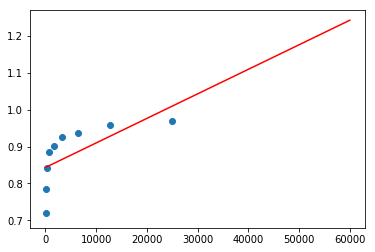

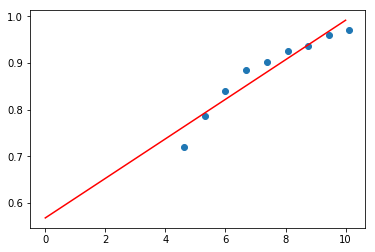

In [9]:
def P4(accuracies, train_sizes, pred, transformation = "linear"):
    '''
    P4(accuracies, train_sizes, pred, transformation = "linear")
    
    - accuracies: list of given accuracies for each corresponding train_size.
    - train_sizes: list of different dataset sizes to train the model.
    - pred: integer for prediction. The number of datapoints that we want to predit accuracy.
    - transformation: string to choose between using the raw data or linear tranformation of the dataset
      as a way of improve linear model fitting. Defaul value is "linear" which means no tranformations
      will be made.
      
    This funcion uses two lists to fit a linear model trying to predict model accuracy using number of
    observations. It also plot the resulting linear model over a scatterplot for visual sanity check.
    There is the option to use a log scale in the train_sizes axis using the metioned input parameter.
    '''
    
    #list to be used for plotting data later.
    predictions = []
    
    if transformation == "linear":
        #turning our train_sizes list in a vector as requested by LinearRegression functions and fitting the model
        train_sizes = np.asarray(train_sizes).reshape(-1, 1)
        regression = LinearRegression()
        
        model_x = train_sizes
        model_y = accuracies
                
        regression.fit(model_x, model_y)
        
        predictions = pred
        
    
    elif transformation == "log":
        train_sizes = np.asarray(train_sizes).reshape(-1, 1)
        regression = LinearRegression()
        
        #applying log tranformation to train_sizes
        model_x = np.log1p(train_sizes)
        model_y = accuracies
        
        regression.fit(model_x, model_y)
        
        predictions = np.log1p(np.asarray(pred))
    
    #little warning message case user input anything other than "linear" or "log" as input to the function
    else: print "Please, use either 'linear' or 'log' scales for regression"
    
    #once the models are fited we plot the scatterplot using a new plot:
    plt.figure()
    
    #ploting a scatter plot to see how the data looks like
    plt.scatter(model_x, model_y)
    
    #adding regression line to check accuracy
    x_vals = np.arange(0,predictions,10)
    y_vals = regression.intercept_ + regression.coef_ * x_vals
    y_vals = np.transpose(y_vals)
    plt.plot(x_vals,y_vals, '-', color = "red")
    
    #print results of the analysis.
    print "Prediction for a {0} training set accuracy: {1:.1f}, using {2} transformation".format(pred, 
                        regression.predict(np.asarray(predictions).reshape(-1,1))[0][0], transformation)
    
#two tests to compare tranformed and  raw data
P4(accuracies, train_sizes, 60000, "linear")
P4(accuracies, train_sizes, 60000, "log")

**ANSWER:** The problem using regression is that the accuracy grows logarithmic as we can easy see in plot 1. Therefore, the linear regression predicts an accuracy of 1.2, wich makes no sense.

For that reason, it is natural we try to apply a log transformation on our data, which results in a model in a better fit and an accuracy prediction close to 1, that makes more sense, but we still know that is not reasonable.

Thinking about how the algorithm works and the amount of data we input, it is also intuitive that the time for calculations grows in logarithmic scale. This is related to the complexity of this algorithm.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

1-Nearest Neighbors model with 1000 training labels accuracy: 0.888


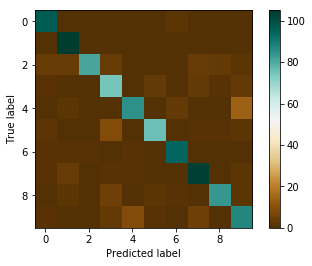

1-Nearest Neighbors model with 60000 training labels accuracy: 0.973111111111


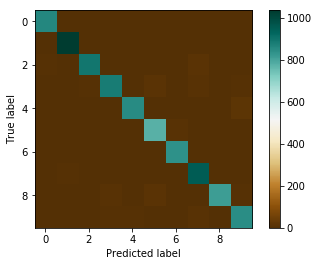

In [10]:
def P5(train_data, train_labels, test_data, test_labels):
    '''
    P5(train_data, train_labels, dev_data, dev_labels)
    
    - train_data: array of matrices of digits used for training the model.
    - train_labels: array of labels of digits that must match train_data.
    - test_data: array of matrices of digits used for testing the model's performance.
    - test_labels: array of labels of digits that must match test_data.
    
    This function plots a confusion matrix of the given train and test datesets using the model defined 
    in function P2.
    '''

    #create model using function P2 (using default value of k_value=[1])
    results = P2(train_data, train_labels, test_data, test_labels)
    
    #plot new figure, using a colormap to improve visualization.
    plt.figure()
    plt.imshow(results[4], cmap="BrBG")
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
#calling the function with our small training dataset and with the full data set for comparison.
P5(mini_train_data, mini_train_labels, dev_data, dev_labels)
P5(train_data, train_labels, test_data, test_labels)

We can see that some common problems on the mini training dataset are between 5s and 3s and between 4s and 9s.

On the main training dataser, however, some other patterns shows up, and we can see confusion in lower scale between 2s and 3s, 8s and 3s and 5s and 8s.

For those reasons, let's plot some examples grouped by the problematic digits:

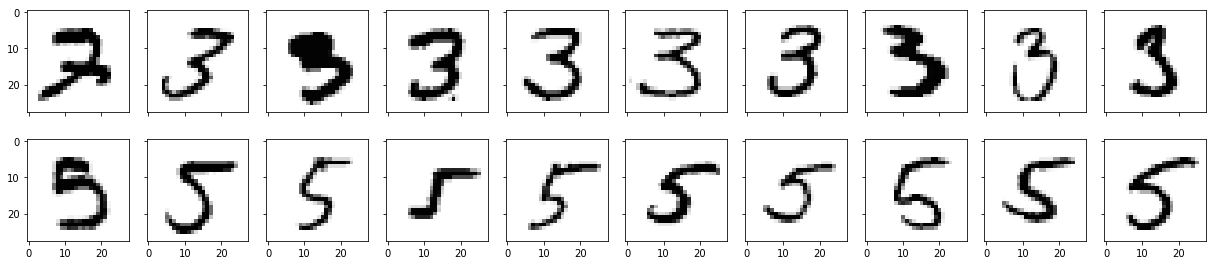

<Figure size 432x288 with 0 Axes>

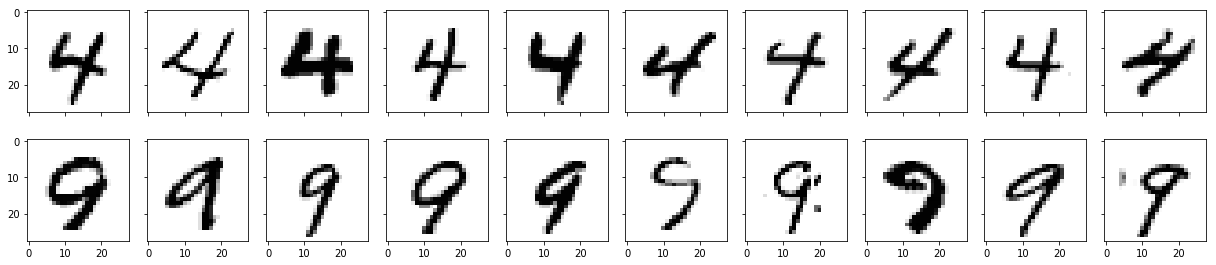

<Figure size 432x288 with 0 Axes>

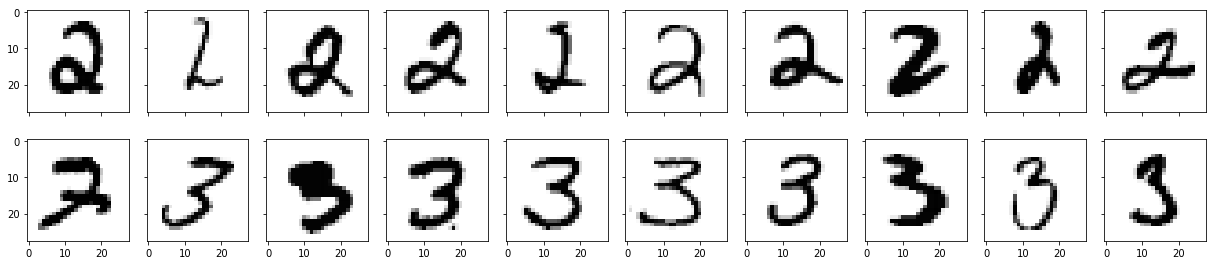

<Figure size 432x288 with 0 Axes>

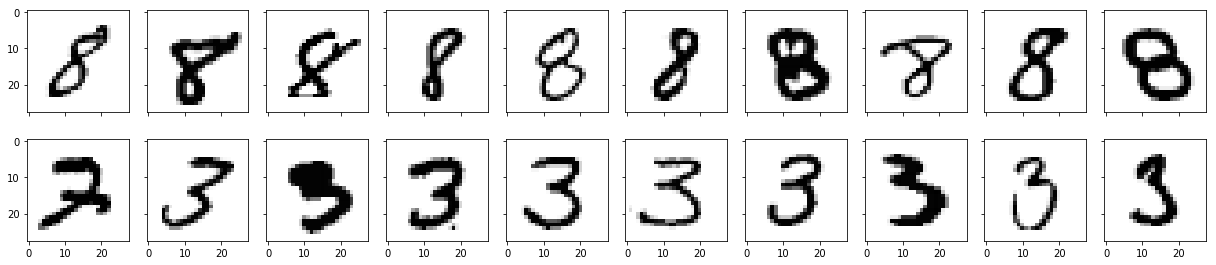

<Figure size 432x288 with 0 Axes>

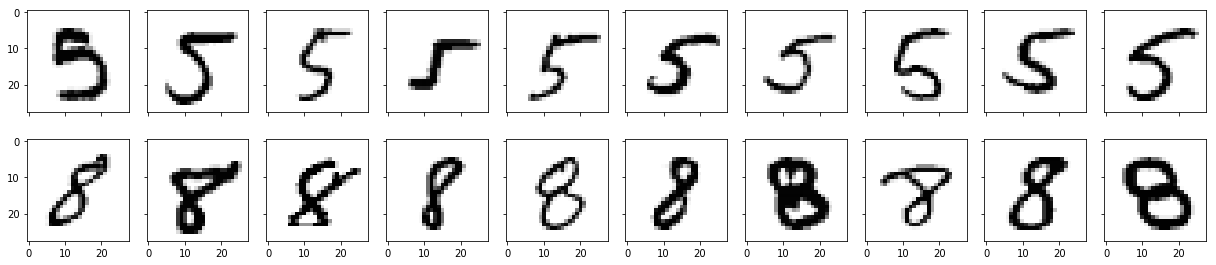

<Figure size 432x288 with 0 Axes>

In [11]:

def P51(data, targets, problems, num_examples=10):
    '''P51(data, targets, num_examples=10, problems)
    
    - data: flat array representing the digits with values within 0~1 to represent ink.
    - targets: flat array with the labels for each of the numbers. Note that the indexes must match the data
      indexes to work. Remember to set the random seed before shiffling the datasets. Default is 10.
    - num_examples: number of examples of each digit to be ploted.
    - problems: list of 2D lists containing digits that we want to check confusion.
    
    Function to visualize 'num_examples' (default=10) examples of 2 digit associated in problems list. The 
    function will plot num_examples grouped by two for comparison effects. '''
    
    examples = num_examples
    
    #re-shuffling the dataset to get observations other than the visualized in P1
    shuffle = np.random.permutation(np.arange(data.shape[0]))
    data, targets = data[shuffle], targets[shuffle]
    
    for i in problems:
        
        set_for_plt = [] #list of desired label indexes, in order.
        for j in i:
            set_for_plt.extend(np.where(targets == j)[0][:num_examples])
            

        data_for_plot = [] #list of arrays that will be ploted.
        for i in set_for_plt:
            data_for_plot.append(data[i])

        #defining the figures to be ploted
        fig, axes = plt.subplots(2,num_examples, 
                             figsize=(17,4),
                             sharex=True, sharey=True,
                             subplot_kw=dict(adjustable='box-forced', aspect='equal'))

        
        #for each data generated one plot is filled:
        for k in range(len(data_for_plot)):

            subplot_row = k//num_examples 
            subplot_col = k%num_examples  
            ax = axes[subplot_row, subplot_col]

            # plot image on subplot
            img = np.reshape(data_for_plot[k], (28,28))
            ax.imshow(img, cmap='Greys')

        
        #figure manipulation for visualization improvement.
        plt.tight_layout()
        plt.show()
        plt.subplots_adjust(bottom=0.7, top= 0.9)


# list of numbers identified as similar on our confusion matrix.
problems = [[3,5], [4,9], [2,3], [8,3], [5,8]]

P51(mini_train_data, mini_train_labels, problems, 10)



(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [44]:
def gaussian_blur(data):
    ''' gaussian_blur(data, size)
    
    - data: ndarray containing digit map.
    
    This function implements a 3x3 Gaussian blur to each pixel in data, which means only the imediate 
    adjacent pixels impacts on one pixel change.
    '''
    
    #reshape to the form of a 2D array (matrix)
    img = np.reshape(data, (28,28))
    
    #will save the results in an alternate array for returning
    res = np.empty([28,28], dtype=float)
    
    #calculate the average of the 8 neighbors for each pixel:
    for i in np.arange(28):
        for j in np.arange(28):
            res[i][j] = (img[max(i-1,0)][max(j-1,0)] + 
                        img[max(i-1,0)][j] + 
                        img[max(i-1,0)][min(j+1,27)] + 
                        img[i][max(j-1,0)] + 
                        img[i][min(j+1,27)] + 
                        img[min(i+1,27)][max(j-1,0)] + 
                        img[min(i+1,27)][j] + 
                        img[min(i+1,27)][min(j+1,27)])/8 
    
    #print res.flatten()
    return res.flatten()
   
def pre_process(data):
    '''
    pre_process(data)
    
    - data: MNIST dataset (array of lengh 784).
    
    This function receives a MNIST dataset and return it fully processed using the implemented 
    gaussian_blur function.
    '''
    
    #processed_ds = np.empty([data.size/data[0].size, data[0].size], dtype=float)
    processed_ds = np.empty([0,784], float)
    
    for i in data:
        processed_ds = np.vstack([processed_ds, gaussian_blur(i)])
    
    return processed_ds    
    

def P6(train_data, train_labels, test_data, test_labels):
    """
    P6(train_data, train_labels, test_data, test_labels)
    
    - train_data: array of matrices of digits used for training the model.
    - train_targets: array of labels of digits that must match train_data.
    - test_data: array of matrices of digits used for testing the model's performance.
    - test_targets: array of labels of digits that must match test_data.
    
    This function run different pre-processing options and printing using the already defined function P2.
    The functions used to pre-process the data are set above and are called by pre_process(...) and
    gaussian_blur(...)
    """
    
    print "\nResults for Gaussian Processed Training Data, Raw Test Data: "
    P2(pre_process(train_data), train_labels, test_data, test_labels)
    
    print "\nResults for Raw Training Data, Gaussian Processed Test Data:"
    P2(train_data, train_labels, pre_process(test_data), test_labels)
    
    print "\nResults for Gaussian Processed Training and Test Data:"
    P2(pre_process(train_data), train_labels, pre_process(test_data), test_labels)
    

P6(mini_train_data, mini_train_labels, dev_data, dev_labels)
P6(train_data, train_labels, test_data, test_labels)


Results for Gaussian Processed Training Data, Raw Test Data: 
1-Nearest Neighbors model with 1000 training labels accuracy: 0.911

Results for Raw Training Data, Gaussian Processed Test Data:
1-Nearest Neighbors model with 1000 training labels accuracy: 0.867

Results for Gaussian Processed Training and Test Data:
1-Nearest Neighbors model with 1000 training labels accuracy: 0.903

Results for Gaussian Processed Training Data, Raw Test Data: 
1-Nearest Neighbors model with 60000 training labels accuracy: 0.978666666667

Results for Raw Training Data, Gaussian Processed Test Data:
1-Nearest Neighbors model with 60000 training labels accuracy: 0.965777777778

Results for Gaussian Processed Training and Test Data:
1-Nearest Neighbors model with 60000 training labels accuracy: 0.977222222222


**ANSWER:** Comparing to what we had before, accuracy of 0.888 without any pre-processing, we see that processing only the training data is more effective. When comparing to the 0.973 accuracy on the large training dataset, we observe that the improvement was smaller, but we see that even with around 2.14% of error labels, there is still room for improvement based on the benchmark by Yann Lecun.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

Binomial Naive Bayes model with alpha = 0 and 1000 training labels accuracy: 0.801


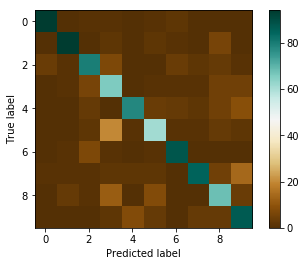

Binomial Naive Bayes model with alpha = 1 and 1000 training labels accuracy: 0.815


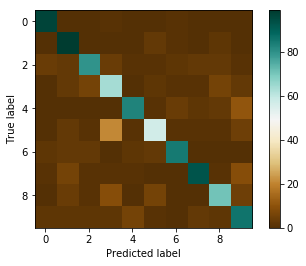

Multinomial Naive Bayes model with alpha = 0 and 1000 training labels accuracy: 0.773


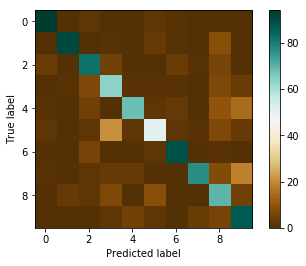

Multinomial Naive Bayes model with alpha = 1 and 1000 training labels accuracy: 0.797


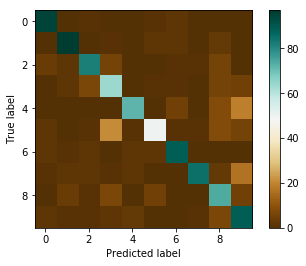

Multinomial Naive Bayes model with alpha = 2 and 1000 training labels accuracy: 0.794


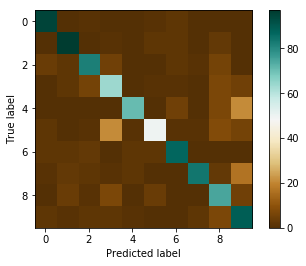

In [205]:
def P7(train_data, train_labels, test_data, test_labels, alpha):
    '''
    P7(train_data, train_labels, test_data, test_labels, alpha)
    
    - train_data: array of matrices of digits used for training the model.
    - train_labels: array of labels of digits that must match train_data.
    - test_data: array of matrices of digits used for testing the model's performance.
    - test_labels: array of labels of digits that must match test_data.
    - alpha: smoothing paramater for the naive bayes model. If alpha=0 no smoothing is applied.
      For further information see sklearn.naive_bayes.BernoulliNB documentation online.
      
    This function takes the given train and test data sets, fits a model using a Bernouli distribution for
    a Naive Bayes algorithm. The threshold to binarize the data is 0.5. After all, the function reports the
    model accuracy and plot the resultant confusion matrix.
    '''
    # fitting the model. Binarize set to 0.5, i.e., pixels with values lower than 0.5 will be converted to
    # 0, the remainers will be converted to 1.
    mod = BernoulliNB(alpha=alpha, binarize=0.5, fit_prior=True, class_prior=None)
    mod.fit(train_data, train_labels)
 
    
    predicted = mod.predict(test_data)
    trues = test_labels
    
    conf_matrix = confusion_matrix(trues, predicted)
    accuracy = float(np.trace(conf_matrix))/np.sum(conf_matrix)
    
    print 'Binomial Naive Bayes model with alpha = {0} and {1} training labels accuracy: {2:.3f}'.format(alpha, 
                                                                                            np.sum(conf_matrix), 
                                                                                            accuracy)
    #ploting confusion matrix, similar to what I did in the previous functions.
    plt.figure()
    plt.imshow(conf_matrix, cmap="BrBG")
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
        
    return mod

def P71(train_data, train_labels, test_data, test_labels, alpha, buckets = 3):
    '''
    P71(train_data, train_labels, test_data, test_labels, buckets)
    
    - train_data: array of matrices of digits used for training the model.
    - train_labels: array of labels of digits that must match train_data.
    - test_data: array of matrices of digits used for testing the model's performance.
    - test_labels: array of labels of digits that must match test_data.
    - alpha: smoothing paramater for the naive bayes model. If alpha=0 no smoothing is applied.
    - buckets: number of possible buckets to fir each pixe.
    
    For further information see sklearn.naive_bayes.MultinomialNB documentation online.
      
    This function takes the given train and test data sets, fits a model using a Multinomial distribution for
    a Naive Bayes algorithm. The function will remap each element of the training value given it's pixels a
    discrete value in the range of [0:buckets].
    After running, the function will plot an example digit, the model accuracy and it's confusion matrix.
    '''
    
    # fitting the model. The train data set will use the remap_pixels functions found further on this cell.
    mod = MultinomialNB(alpha=alpha, fit_prior=True, class_prior=None)
    mod.fit(remap_pixels(train_data, buckets=3), train_labels)
 
    predicted = mod.predict(test_data)
    trues = test_labels
    
    conf_matrix = confusion_matrix(trues, predicted)
    accuracy = float(np.trace(conf_matrix))/np.sum(conf_matrix)
    
    print 'Multinomial Naive Bayes model with alpha = {0} and {1} training labels accuracy: {2:.3f}'.format(alpha, 
                                                                                            np.sum(conf_matrix), 
                                                                                            accuracy)
    #ploting confusion matrix, similar to what I did in the previous functions.
    plt.figure()
    plt.imshow(conf_matrix, cmap="BrBG")
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
    
#setup a function to pre-process the training dataset according to the number of buckets required.
def remap_pixels(data, buckets=3):
    '''
    remap_pixels(data, buckets)
    
    - data: array of matrices of digits that will be preprocessed.
    - buckets: number of classes that the processed dataset will have for each pixel.
      
    This function takes a dataset of MNIST digits and convert each pixel to an integer between 0 and buckets-1.
    '''
    #list for the buckets limits
    limits = []
    
    # creating the limit values for each bucket. 
    # for the default case we want, for example: [0.33,0.66]
    for i in range(1,buckets):
        limits.append(float(i)/buckets)
    
    #creating an array for storing the processed dataset:
    processed_data = np.empty([0,784], int)
    
    #for each element in data, transform the pixels to an integer value (0,1 or 2 in the default case)
    for i in data:
        processed_data = np.vstack([processed_data, np.digitize(i, np.asarray(limits), right=True)])
    
    #print one example for sanity check:
    #print "Example of remaped digit:"
    #img = np.reshape(processed_data[0], (28,28))
    #plt.imshow(img, cmap="Greys")
    
    return processed_data
    

micro_ds = mini_train_data[:10]
micro_ds_lab = mini_train_labels[:10]
#remap_pixels(micro_ds)    
    
P7(mini_train_data, mini_train_labels, dev_data, dev_labels, alpha=0)
P7(mini_train_data, mini_train_labels, dev_data, dev_labels, alpha=1)

P71(mini_train_data, mini_train_labels, dev_data, dev_labels, alpha = 0, buckets = 3)
P71(mini_train_data, mini_train_labels, dev_data, dev_labels, alpha = 1, buckets = 3)

P71(mini_train_data, mini_train_labels, dev_data, dev_labels, alpha = 2, buckets = 10)


**ANSWER:** According to the accuracy metric that we are using, the multinomial approach does not improve the results. 

As the Naive Bayes algorithm is based on the assumption that the features distribution are mutually independent, increasing the number of possible values for the features weakens that assumption, because pixels near black pictures are more likely to be gray, for example. Therefore, increasing the number of possible values for the features to numbers like 10, degrades our performance.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

Binomial Naive Bayes model with alpha = 0.01 and 1000 training labels accuracy: 0.818


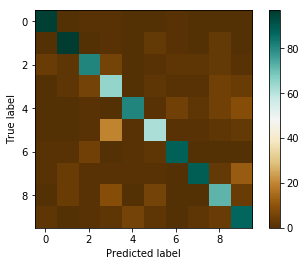

In [112]:
def P8(alphas, train_data, train_labels):
    '''
    P8(alphas, train_data, train_labels)
    
    - dictionary with different alpha parameters to run the models and compare.
    - train_data: array of matrices of digits used for training the model.
    - train_labels: array of labels of digits that must match train_data.
    
    This function returns a GridSearchCV object that compares the performances for each 
    given alpha value.
    '''

    mod = BernoulliNB(binarize=0.5, fit_prior=True, class_prior=None)
    clf = GridSearchCV(mod, param_grid=alphas)
    clf.fit(train_data, train_labels)
    
    return clf
    
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

nb = P8(alphas, mini_train_data, mini_train_labels)

{'alpha': 0.01}
[mean: 0.80300, std: 0.01644, params: {'alpha': 0.0}, mean: 0.81800, std: 0.02216, params: {'alpha': 0.0001}, mean: 0.82000, std: 0.02073, params: {'alpha': 0.001}, mean: 0.82100, std: 0.01811, params: {'alpha': 0.01}, mean: 0.81500, std: 0.02013, params: {'alpha': 0.1}, mean: 0.80000, std: 0.01188, params: {'alpha': 0.5}, mean: 0.79500, std: 0.01145, params: {'alpha': 1.0}, mean: 0.78400, std: 0.01934, params: {'alpha': 2.0}, mean: 0.72000, std: 0.02495, params: {'alpha': 10.0}]
Binomial Naive Bayes model with alpha = 0.01 and 1000 training labels accuracy: 0.818


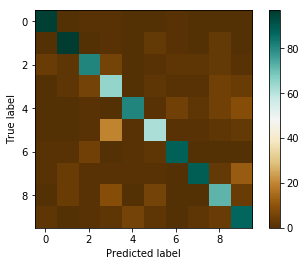

In [130]:
print nb.best_params_

P7(mini_train_data, mini_train_labels, dev_data, dev_labels, alpha=0.01)

**ANSWER:** AS we saw in the previous topic, the accuracy for alpha = 0 is 0.801, while using the best value for alpha, 0.01, is 0.818, against 0.815 from the default alpha = 1. Although this was not expected, this shows us that smoothing the image is not always a gain, but can be helpful.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

Binomial Naive Bayes model with 1000 training labels accuracy: 0.621


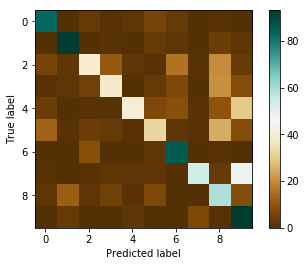

In [134]:
def P9(train_data, train_labels, test_data, test_labels, var_smothing = 1e-09):
    '''
    P9(train_data, train_labels, test_data, test_labels, var_smothing)
    
    - train_data: array of matrices of digits used for training the model.
    - train_labels: array of labels of digits that must match train_data.
    - test_data: array of matrices of digits used for testing the model's performance.
    - test_labels: array of labels of digits that must match test_data.
    - var_smothing:ortion of the largest variance of all features that is added to 
      variances for calculation stability. Default is set to GaussianNB default parameter.
      See sklearn.naive_bayes.GaussianNB documentation online for further detail
      
    This function takes the given train and test data sets, fits a model using the Gaussian Naive Bayes
    algorith and reports the outputs as an accuracy test and a confusion matrix.
    '''
    # fitting the model.
    mod = GaussianNB()
    mod.fit(train_data, train_labels)
    
    predicted = mod.predict(test_data)
    trues = test_labels
    
    conf_matrix = confusion_matrix(trues, predicted)
    accuracy = float(np.trace(conf_matrix))/np.sum(conf_matrix)
    
    print 'Binomial Naive Bayes model with {0} training labels accuracy: {1:.3f}'.format(np.sum(conf_matrix), 
                                                                                            accuracy)
    #ploting confusion matrix, similar to what I did in the previous functions.
    plt.figure()
    plt.imshow(conf_matrix, cmap="BrBG")
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return mod

gnb = P9(mini_train_data, mini_train_labels, dev_data, dev_labels)

**ANSWER:** Once the Gaussian Naive Bayes model was built to deal with real-valued data, it performance poorly with nearly discrete data as in this dataset. Even trying to smooth the data using the gaussian_blur function used before was not enough, so I decided to add some noise in our data, making its distribution more like a gaussian curve. This can be verified using looking at the histograms of the means for each pixel using 'model.theta' parameter: there is way more 0s in our models, which are the 'white' spaces when we plot the digits.

(array([4.599e+03, 3.710e+02, 2.880e+02, 2.200e+02, 1.990e+02, 1.420e+02,
        1.520e+02, 1.370e+02, 1.100e+02, 1.450e+02, 1.190e+02, 1.130e+02,
        1.290e+02, 1.240e+02, 1.190e+02, 1.300e+02, 1.340e+02, 1.280e+02,
        1.020e+02, 8.800e+01, 8.100e+01, 4.900e+01, 5.900e+01, 4.400e+01,
        2.100e+01, 1.400e+01, 1.200e+01, 6.000e+00, 3.000e+00, 2.000e+00]),
 array([0.        , 0.03146381, 0.06292761, 0.09439142, 0.12585522,
        0.15731903, 0.18878283, 0.22024664, 0.25171045, 0.28317425,
        0.31463806, 0.34610186, 0.37756567, 0.40902947, 0.44049328,
        0.47195708, 0.50342089, 0.5348847 , 0.5663485 , 0.59781231,
        0.62927611, 0.66073992, 0.69220372, 0.72366753, 0.75513134,
        0.78659514, 0.81805895, 0.84952275, 0.88098656, 0.91245036,
        0.94391417]),
 <a list of 30 Patch objects>)

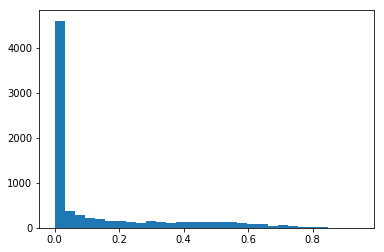

In [143]:
plt.figure()
plt.hist(gnb.theta_.flatten(),30)

Binomial Naive Bayes model with 1000 training labels accuracy: 0.807


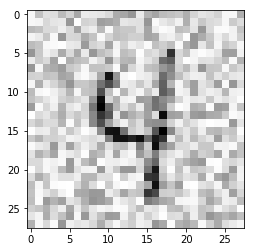

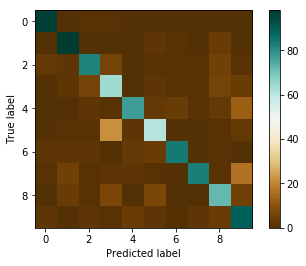

(array([9.600e+01, 8.920e+02, 2.150e+03, 1.485e+03, 5.290e+02, 2.860e+02,
        2.120e+02, 1.800e+02, 1.670e+02, 1.630e+02, 1.470e+02, 1.290e+02,
        1.370e+02, 1.440e+02, 1.380e+02, 1.440e+02, 1.470e+02, 1.370e+02,
        1.390e+02, 9.300e+01, 8.100e+01, 8.100e+01, 5.800e+01, 4.900e+01,
        2.300e+01, 1.300e+01, 1.200e+01, 5.000e+00, 1.000e+00, 2.000e+00]),
 array([0.4087094 , 0.44428218, 0.47985496, 0.51542773, 0.55100051,
        0.58657329, 0.62214606, 0.65771884, 0.69329162, 0.72886439,
        0.76443717, 0.80000995, 0.83558272, 0.8711555 , 0.90672828,
        0.94230105, 0.97787383, 1.01344661, 1.04901938, 1.08459216,
        1.12016494, 1.15573771, 1.19131049, 1.22688327, 1.26245604,
        1.29802882, 1.3336016 , 1.36917437, 1.40474715, 1.44031993,
        1.4758927 ]),
 <a list of 30 Patch objects>)

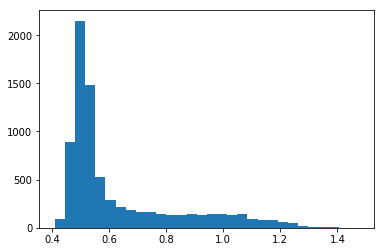

In [162]:
#Adding randon noise to training data set to improve GaussianNB performance:
def add_noise(data):
    '''
    add_noise(data)
    
    - data: array containing our training dataset.
    
    This function add random noise to each feature (pixel) of the inputed dataset, returning a transformed one.
    '''
    noisy_data = [] = np.empty([0,784], float)
    
    #for each element in data, add random noise to the pixels 
    for i in data:
        noisy_data = np.vstack([noisy_data, i + np.random.random(size = i.size)])
        
    #print a number for sanity check
    #print noisy_data[0]
    img = np.reshape(noisy_data[0], (28,28))
    plt.imshow(img, cmap='Greys')
    
    return noisy_data
    
gnb2 = P9(add_noise(mini_train_data), mini_train_labels, add_noise(dev_data), dev_labels)

plt.hist(gnb2.theta_.flatten(),30)

Now we have a better distribution and the performance was closer to the Binomial algorithm.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

Binomial Naive Bayes model with alpha = 0.01 and 1000 training labels accuracy: 0.818


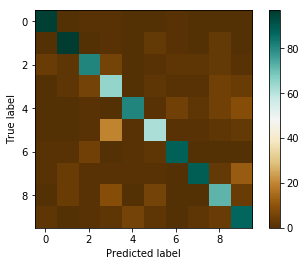

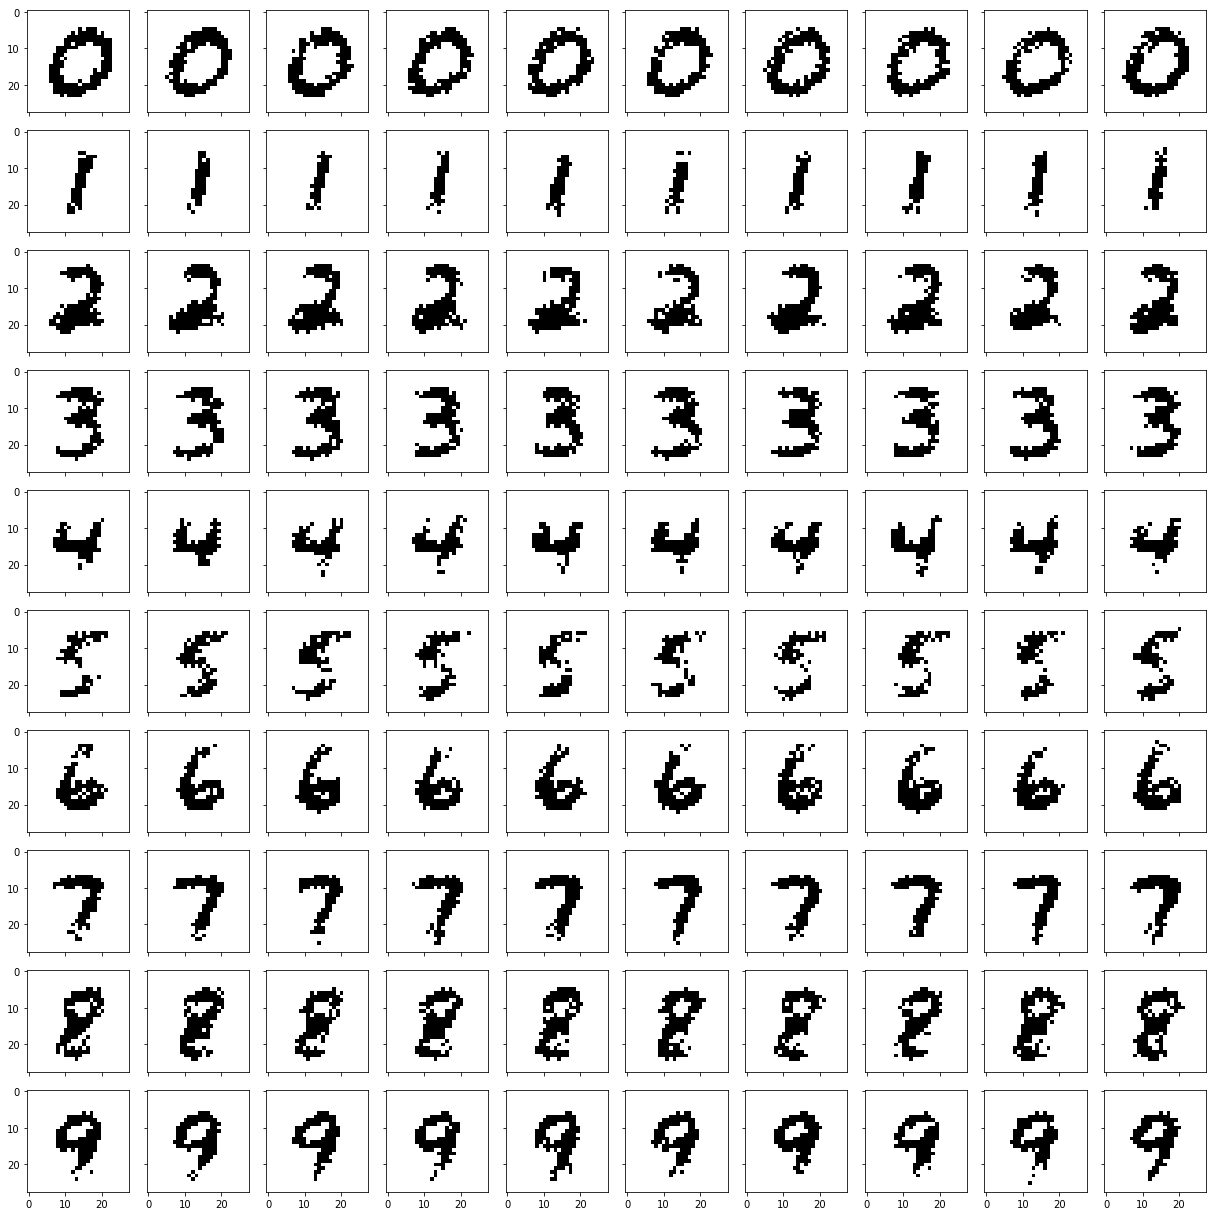

In [216]:
def P10(num_examples, train_data, train_labels, test_data, test_labels, alpha):
    '''
    P10(num_examples, train_data, train_labels, test_data, test_labels, alpha)
    
    - num_examples: integer with number of examples of each digit to plot.
    - train_data: array of matrices of digits used for training the model.
    - test_data: array of matrices of digits used for testing the model's performance.
    - test_labels: array of labels of digits that must match test_data.
    - train_labels: array of labels of digits that must match train_data.
    - alpha: smoothing parameter for the BernoulliNB algorithm training.
    
    This function uses previous ones P7 and P1 to respectively train a Bernoulli Naive Bayes algorithm, 
    generate new digits based on that model and plot in a num_examples x 10 matrix.
    '''

    mod = P7(train_data, train_labels, test_data, test_labels, alpha = alpha)
    
    pixels_probab =  np.exp(mod.feature_log_prob_)
    
    new_labels = np.empty([0])
    for i in range(num_examples):
        new_labels = np.append(new_labels, np.full((num_examples),i))

    new_data = np.empty([0,784])
    for i in range(10):
        for j in range(num_examples):
            new_data = np.vstack([new_data,pixels_probab[i] > np.random.uniform(low = 0.3, high = 0.6, size=784)])
    
    P1(new_data, new_labels, num_examples)
    

P10(10, mini_train_data, mini_train_labels, dev_data, dev_labels, 0.01)


**ANSWER:** As I added a random array to be my threshold, with fairly tight limits (0.3 to 0.6) the digits are pretty readable, however they also seen similar between each other. We can change that, but the digits would loose their shape more and more.  

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

Binomial Naive Bayes model with alpha = 0.01 and 9000 training labels accuracy: 0.839


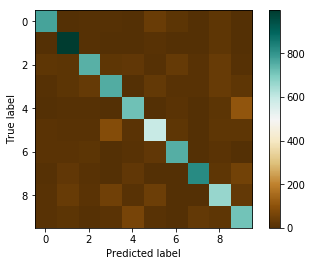

p(pred) <= 0.5000000000000    total =   4    accuracy = 0.500
p(pred) <= 0.9000000000000    total = 381    accuracy = 0.404
p(pred) <= 0.9990000000000    total = 814    accuracy = 0.493
p(pred) <= 0.9999900000000    total = 689    accuracy = 0.644
p(pred) <= 0.9999999000000    total = 720    accuracy = 0.713
p(pred) <= 0.9999999990000    total = 643    accuracy = 0.788
p(pred) <= 0.9999999999900    total = 644    accuracy = 0.882
p(pred) <= 0.9999999999999    total = 560    accuracy = 0.932
p(pred) <= 1.0000000000000    total = 4545    accuracy = 0.977


In [227]:
def P11(train_data, train_labels, test_data, test_labels, buckets, correct, total, alpha = 1):
    '''
    P11(train_data, train_labels, test_data, test_labels, alpha = 1, buckets, correct, total)
    
    - train_data: array of matrices of digits used for training the model.
    - train_labels: array of labels of digits that must match train_data.
    - test_data: array of matrices of digits used for testing the model's performance.
    - test_labels: array of labels of digits that must match test_data.
    - alpha: smoothing paramater for the naive bayes model. If alpha=0 no smoothing is applied.
      For further information see sklearn.naive_bayes.BernoulliNB documentation online.
    - buckets:
    - correct:
    - total:
    
    This function uses the given training and test to fit a BernoulliNB model using function P7 and test its
    accuracy using different values for different values of posterior probablities contained in list buckets.
    The results are printed together with the accuracy for each posterior probability bucket.
    '''
    #use P7 function to train the model:
    mod = P7(train_data, train_labels, test_data, test_labels, alpha = alpha)

    predictions = mod.predict(test_data)
    pred_probabilities = mod.predict_proba(test_data)
    
    for i, j in enumerate(predictions):
        max_probability = max(pred_probabilities[i])
        bucket = sum(max_probability > buckets)
        correct[bucket] += 1 if j == test_labels[i] else 0
        total[bucket] += 1
        #print correct[bucket], total[bucket]
        
    return (correct, total)
    
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(train_data, train_labels, test_data, test_labels, buckets, correct, total, 0.01)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = float(correct[i]) / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

**ANSWER:** AS expected, the calibration seems good, once that when p(pred) -> 1, the accuracy of the model goes as well.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [137]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()